In [129]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
np.random.seed(1)
torch.manual_seed(1) # PyTorch seed for reproducibility

Run the next cell to load the "SIGNS" dataset you are going to use.

In [130]:
def load_dataset():
    train_dataset = h5py.File('./train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [131]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Preprocessing the data for PyTorch
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape Y to be (m,) for PyTorch's CrossEntropyLoss
Y_train = Y_train_orig.T.squeeze()
Y_test = Y_test_orig.T.squeeze()

# Reshape X to PyTorch's channel-first format: (m, C, H, W) from (m, H, W, C)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Define a simple Dataset class
class SignDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

y = 3


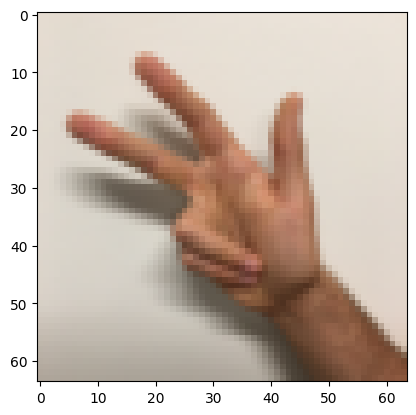

In [132]:
index = 25
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [133]:
class ConvNet(nn.Module):
    """
    Implements the CNN architecture from the assignment using PyTorch.

    Architecture: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    PyTorch's nn.Module encapsulates parameter initialization and the forward pass.
    """
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()

        # CONV2D 1: 8 filters, F=4, S=1, Padding='SAME' (using P=1 for approximate 'SAME' behavior in a 64x64 context)
        # Input: (m, 3, 64, 64). Output: (m, 8, 63, 63)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=1, padding=1)
        # MAXPOOL 1: F=8, S=8. Output: (m, 8, 8, 8)
        self.pool1 = nn.MaxPool2d(kernel_size=8, stride=8)

        # CONV2D 2: 16 filters, F=2, S=1, Padding='SAME' (using P=1 for approximate 'SAME' behavior)
        # Input: (m, 8, 8, 8). Output: (m, 16, 9, 9)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=1)
        # MAXPOOL 2: F=4, S=4. Output: (m, 16, 2, 2)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)

        # FLATTEN -> FULLYCONNECTED
        # Input features: 16 * 2 * 2 = 64
        self.fc = nn.Linear(in_features=16 * 2 * 2, out_features=num_classes)

    def forward(self, x):
        # CONV1 -> RELU -> MAXPOOL1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # CONV2 -> RELU -> MAXPOOL2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # FLATTEN -> FULLYCONNECTED
        # PyTorch uses torch.flatten (start_dim=1 to preserve batch dimension)
        F_flat = torch.flatten(x, 1)
        z = self.fc(F_flat)
        return z

In [134]:
class LeNet(nn.Module):
    """
    LeNet-5-like architecture adapted for 3x64x64 inputs while keeping
    the original LeNet building blocks (tanh activations, average pooling,
    and the Conv->Conv->Conv->FC pipeline).
    
    Architecture (structure follows LeNet-5):
    CONV(3->6, 5x5) -> TANH -> AVGPOOL(2x2)
    CONV(6->16, 5x5) -> TANH -> AVGPOOL(2x2)
    CONV(16->120, 5x5) -> TANH
    FLATTEN -> FC(120*spatial -> 84) -> TANH -> FC(84 -> num_classes)
    
    Notes:
    - Input assumed (m, 3, 64, 64).
    - Spatial sizes will differ from original 32x32 LeNet, but layer ordering
      and non-linearities match LeNet-5.
    """
    def __init__(self, num_classes=6):
        super(LeNet, self).__init__()
        # conv1: 3 -> 6, kernel 5, no padding (64 -> 60)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 60 -> 30

        # conv2: 6 -> 16, kernel 5, no padding (30 -> 26)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 26 -> 13

        # conv3: 16 -> 120, kernel 5, no padding (13 -> 9)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)

        # After conv3: channels = 120, spatial = 9 x 9 -> flattened features = 120 * 9 * 9
        self.fc1 = nn.Linear(in_features=120 * 9 * 9, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=num_classes)

        # Tanh activation to follow original LeNet behavior
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.tanh(x)

        x = torch.flatten(x, 1)  # preserve batch dim
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

In [135]:
def initialize_parameters():
    """
    In PyTorch, parameters are initialized inside the nn.Module's __init__ method.
    This function is redefined to simply print the model structure and check the parameters.
    """
    conv_model = LeNet(num_classes=6)
    print(conv_model)
    # Example of viewing parameters
    print("Parameters:")
    for name, param in conv_model.named_parameters():
        if 'weight' in name and len(param.shape) > 1:
            print(f"{name} size: {param.size()}")
    
    return conv_model.state_dict()

parameters = initialize_parameters()


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9720, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=6, bias=True)
  (tanh): Tanh()
)
Parameters:
conv1.weight size: torch.Size([6, 3, 5, 5])
conv2.weight size: torch.Size([16, 6, 5, 5])
conv3.weight size: torch.Size([120, 16, 5, 5])
fc1.weight size: torch.Size([84, 9720])
fc2.weight size: torch.Size([6, 84])


In [136]:
# The forward propagation is now implemented within the ConvNet class's forward method.
# PyTorch uses nn.Module which combines the parameter initialization and forward pass.

# Test the forward pass with a dummy tensor (adapted from original test code)
# Note: PyTorch expects channel-first (m, C, H, W)
torch.manual_seed(1)
X = torch.randn(2, 3, 64, 64) # (m, C, H, W)
conv_model = LeNet(num_classes=6)
Z3 = conv_model(X)
print("Z3 = " + str(Z3.detach().numpy())) # print the output of the final layer

Z3 = [[ 0.01621242  0.02962117 -0.11943388  0.05362014 -0.04783561 -0.09637079]
 [-0.01393669  0.03900696 -0.09053347  0.04696447 -0.01369031 -0.08732825]]


In [137]:
def compute_cost(Z3, Y):
    """
    Computes the cost (loss) using PyTorch's CrossEntropyLoss.
    
    Arguments:
    Z3 -- output of the last linear unit (logits), tensor of shape (batch_size, num_classes)
    Y -- true labels, tensor of shape (batch_size,) with integer class labels
        
    Returns:
    cost - scalar, the cost value
    """
    cost_function = nn.CrossEntropyLoss()
    cost = cost_function(Z3, Y)
    
    return cost

# Test the cost function (adapted from original test code)
# Note: Z3 must be (m, num_classes), Y must be (m,) of type long
torch.manual_seed(1)
Z3 = torch.randn(4, 6, dtype=torch.float32)
Y = torch.randint(0, 6, (4,), dtype=torch.long)
cost = compute_cost(Z3, Y)
print("cost = " + str(cost.item()))

cost = 1.7490992546081543


In [138]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    """
    Implements LeNetOriginal training + plots both cost and accuracy graphs.
    """
    torch.manual_seed(1)
    seed = 3
    m = len(X_train)
    n_y = Y_train.max().item() + 1
    costs = []
    train_accuracies = []
    test_accuracies = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    conv_model = ConvNet(num_classes=n_y).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(conv_model.parameters(), lr=learning_rate)

    train_dataset = SignDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)

    print(f"Starting training on device: {device}")
    conv_model.train()

    for epoch in range(num_epochs):
        minibatch_cost = 0.
        num_minibatches = max(1, m // minibatch_size)
        seed = seed + 1

        for minibatch_X, minibatch_Y in train_loader:
            minibatch_X = minibatch_X.to(device)
            minibatch_Y = minibatch_Y.to(device)

            optimizer.zero_grad()
            outputs = conv_model(minibatch_X)
            cost = criterion(outputs, minibatch_Y)
            cost.backward()
            optimizer.step()

            minibatch_cost += cost.item() / num_minibatches

        # Record cost
        costs.append(minibatch_cost)

        # ---- Compute accuracy per epoch ----
        conv_model.eval()
        with torch.no_grad():
            # Train accuracy
            X_train_device = X_train.to(device)
            Y_train_device = Y_train.to(device)
            train_preds = torch.argmax(conv_model(X_train_device), dim=1)
            train_acc = (train_preds == Y_train_device).float().mean().item()

            # Test accuracy
            X_test_device = X_test.to(device)
            Y_test_device = Y_test.to(device)
            test_preds = torch.argmax(conv_model(X_test_device), dim=1)
            test_acc = (test_preds == Y_test_device).float().mean().item()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        conv_model.train()  # return to training mode

        if print_cost and epoch % 5 == 0:
            print(f"Epoch {epoch}: cost={minibatch_cost:.4f}, train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    ax1.plot(np.arange(num_epochs), costs, color=color, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(np.arange(num_epochs), train_accuracies, color='tab:blue', linestyle='-', label='Train Accuracy')
    ax2.plot(np.arange(num_epochs), test_accuracies, color='tab:green', linestyle='--', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right')

    plt.title("Cost and Accuracy vs Epochs (LeNet-5 original style)")
    plt.show()

    print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Test Accuracy:  {test_accuracies[-1]:.4f}")

    return conv_model.state_dict()

Starting training on device: cuda:0
Epoch 0: cost=1.9105, train_acc=0.1593, test_acc=0.1750
Epoch 5: cost=1.9042, train_acc=0.1648, test_acc=0.1833
Epoch 10: cost=1.9012, train_acc=0.1639, test_acc=0.1833
Epoch 15: cost=1.8989, train_acc=0.1630, test_acc=0.2000
Epoch 20: cost=1.8970, train_acc=0.2194, test_acc=0.2583
Epoch 25: cost=1.8945, train_acc=0.2481, test_acc=0.3000
Epoch 30: cost=1.8917, train_acc=0.2824, test_acc=0.3417
Epoch 35: cost=1.8884, train_acc=0.3519, test_acc=0.4167
Epoch 40: cost=1.8844, train_acc=0.4046, test_acc=0.4667
Epoch 45: cost=1.8796, train_acc=0.4083, test_acc=0.4500
Epoch 50: cost=1.8735, train_acc=0.4370, test_acc=0.4667
Epoch 55: cost=1.8663, train_acc=0.4528, test_acc=0.4667
Epoch 60: cost=1.8574, train_acc=0.4398, test_acc=0.4667
Epoch 65: cost=1.8470, train_acc=0.4556, test_acc=0.4583
Epoch 70: cost=1.8340, train_acc=0.4565, test_acc=0.4667
Epoch 75: cost=1.8208, train_acc=0.4657, test_acc=0.4583
Epoch 80: cost=1.8036, train_acc=0.4583, test_acc=0.48

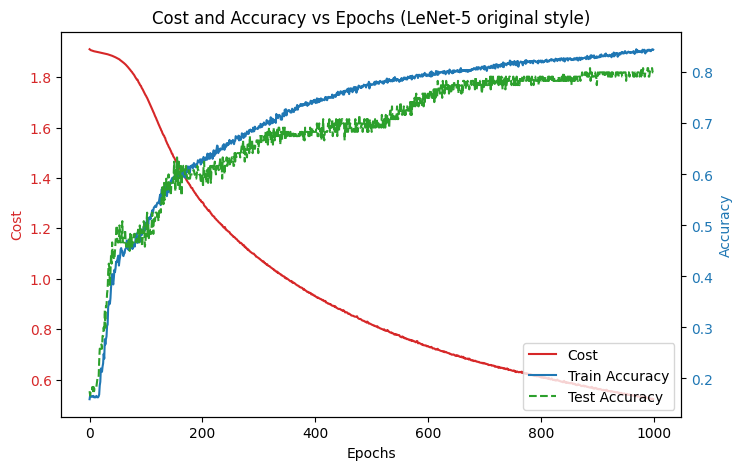

Final Train Accuracy: 0.8444
Final Test Accuracy:  0.8000


In [139]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [140]:
# The forward propagation is now implemented within the ConvNet class's forward method.
# PyTorch uses nn.Module which combines the parameter initialization and forward pass.

# Test the forward pass with a dummy tensor (adapted from original test code)
# Note: PyTorch expects channel-first (m, C, H, W)
torch.manual_seed(1)
X = torch.randn(2, 3, 64, 64) # (m, C, H, W)
conv_model = LeNet(num_classes=6)
Z3 = conv_model(X)
print("Z3 = " + str(Z3.detach().numpy())) # print the output of the final layer

Z3 = [[ 0.01621242  0.02962117 -0.11943388  0.05362014 -0.04783561 -0.09637079]
 [-0.01393669  0.03900696 -0.09053347  0.04696447 -0.01369031 -0.08732825]]


##  Compute Cost

The cost function is computed using **PyTorch's `nn.CrossEntropyLoss`**. This loss function is a combination of `nn.LogSoftmax` and `nn.NLLLoss`, which is the equivalent of TensorFlow's `tf.nn.softmax_cross_entropy_with_logits` when using integer class labels.

In [141]:
def compute_cost(Z3, Y):
    """
    Computes the cost (loss) using PyTorch's CrossEntropyLoss.
    
    Arguments:
    Z3 -- output of the last linear unit (logits), tensor of shape (batch_size, num_classes)
    Y -- true labels, tensor of shape (batch_size,) with integer class labels
        
    Returns:
    cost - scalar, the cost value
    """
    cost_function = nn.CrossEntropyLoss()
    cost = cost_function(Z3, Y)
    
    return cost

# Test the cost function (adapted from original test code)
# Note: Z3 must be (m, num_classes), Y must be (m,) of type long
torch.manual_seed(1)
Z3 = torch.randn(4, 6, dtype=torch.float32)
Y = torch.randint(0, 6, (4,), dtype=torch.long)
cost = compute_cost(Z3, Y)
print("cost = " + str(cost.item()))

cost = 1.7490992546081543


##  Model

You are now ready to put all the pieces together into a full ConvNet model in **PyTorch**. 

In [144]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 500, minibatch_size = 64, print_cost = True):
    """
    Implements LeNetOriginal training + plots both cost and accuracy graphs.
    """
    torch.manual_seed(1)
    seed = 3
    m = len(X_train)
    n_y = Y_train.max().item() + 1
    costs = []
    train_accuracies = []
    test_accuracies = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    conv_model = LeNet(num_classes=n_y).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(conv_model.parameters(), lr=learning_rate)

    train_dataset = SignDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)

    print(f"Starting training on device: {device}")
    conv_model.train()

    for epoch in range(num_epochs):
        minibatch_cost = 0.
        num_minibatches = max(1, m // minibatch_size)
        seed = seed + 1

        for minibatch_X, minibatch_Y in train_loader:
            minibatch_X = minibatch_X.to(device)
            minibatch_Y = minibatch_Y.to(device)

            optimizer.zero_grad()
            outputs = conv_model(minibatch_X)
            cost = criterion(outputs, minibatch_Y)
            cost.backward()
            optimizer.step()

            minibatch_cost += cost.item() / num_minibatches

        # Record cost
        costs.append(minibatch_cost)

        # ---- Compute accuracy per epoch ----
        conv_model.eval()
        with torch.no_grad():
            # Train accuracy
            X_train_device = X_train.to(device)
            Y_train_device = Y_train.to(device)
            train_preds = torch.argmax(conv_model(X_train_device), dim=1)
            train_acc = (train_preds == Y_train_device).float().mean().item()

            # Test accuracy
            X_test_device = X_test.to(device)
            Y_test_device = Y_test.to(device)
            test_preds = torch.argmax(conv_model(X_test_device), dim=1)
            test_acc = (test_preds == Y_test_device).float().mean().item()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        conv_model.train()  # return to training mode

        if print_cost and epoch % 5 == 0:
            print(f"Epoch {epoch}: cost={minibatch_cost:.4f}, train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    ax1.plot(np.arange(num_epochs), costs, color=color, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(np.arange(num_epochs), train_accuracies, color='tab:blue', linestyle='-', label='Train Accuracy')
    ax2.plot(np.arange(num_epochs), test_accuracies, color='tab:green', linestyle='--', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right')

    plt.title("Cost and Accuracy vs Epochs (LeNet-5 original style)")
    plt.show()

    print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Test Accuracy:  {test_accuracies[-1]:.4f}")

    return conv_model.state_dict()

Starting training on device: cuda:0
Epoch 0: cost=1.8846, train_acc=0.3000, test_acc=0.2750
Epoch 5: cost=0.6520, train_acc=0.8583, test_acc=0.8583
Epoch 10: cost=0.2796, train_acc=0.8796, test_acc=0.8167
Epoch 15: cost=0.1247, train_acc=0.9907, test_acc=0.9250
Epoch 20: cost=0.0532, train_acc=0.9981, test_acc=0.9250
Epoch 25: cost=0.0323, train_acc=0.9991, test_acc=0.9167
Epoch 30: cost=0.0229, train_acc=0.9991, test_acc=0.9333
Epoch 35: cost=0.0176, train_acc=0.9991, test_acc=0.9417
Epoch 40: cost=0.0141, train_acc=0.9991, test_acc=0.9417
Epoch 45: cost=0.0114, train_acc=0.9991, test_acc=0.9417
Epoch 50: cost=0.0094, train_acc=0.9991, test_acc=0.9417
Epoch 55: cost=0.0078, train_acc=0.9991, test_acc=0.9333
Epoch 60: cost=0.0065, train_acc=0.9991, test_acc=0.9417
Epoch 65: cost=0.0054, train_acc=1.0000, test_acc=0.9333
Epoch 70: cost=0.0045, train_acc=1.0000, test_acc=0.9333
Epoch 75: cost=0.0039, train_acc=1.0000, test_acc=0.9250
Epoch 80: cost=0.0033, train_acc=1.0000, test_acc=0.93

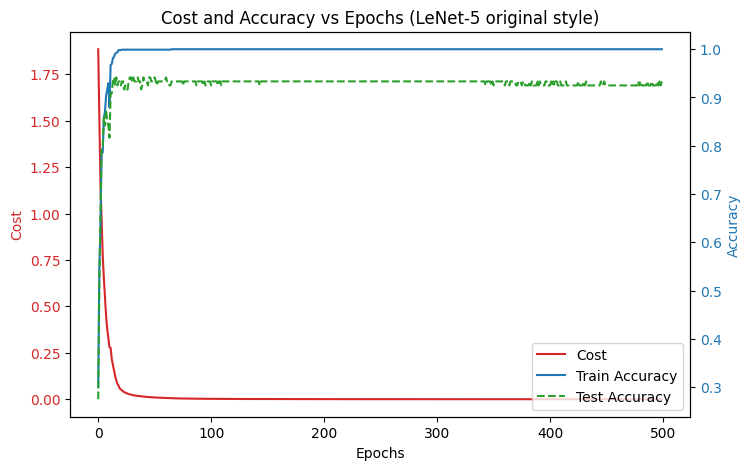

Final Train Accuracy: 1.0000
Final Test Accuracy:  0.9333


In [145]:
# The accuracy will be printed inside the model function call
parameters = model(X_train, Y_train, X_test, Y_test)